In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np


# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = "data\\"+file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

#date to date format and sorting with it

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['user', 'date'])

#first messege for each user
data['first_message'] = data.groupby('user').cumcount().apply(lambda x: 1 if x == 0 else 0)


# Calculate the number of first messages per stream
first_messages_per_stream = data.groupby('stream')['first_message'].sum()


# Calculate the total number of messages per stream
total_messages_per_stream = data['stream'].value_counts()

# Combine the results into a single DataFrame
stream_stats = pd.DataFrame({
    'first_messages': first_messages_per_stream,
    'total_messages': total_messages_per_stream
})

# Calculate the time difference between the first and last messages for each stream
stream_lengths = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())

# Add the stream_length column to the stream_stats DataFrame
stream_stats['stream_length'] = stream_lengths

#stream length pre hour
stream_stats['stream_length_hour'] = stream_stats['stream_length'] /60 /60

# Path to your Excel file
file_path = 'DorozeaStreamStats.xlsx'

# Reading a specific sheet with custom column names and skipping the first two rows
exelStats = pd.read_excel(file_path, sheet_name='Munkalap1', header=None, names=['stream', 'avg', 'max','follow','games'], skiprows=1)

stream_stats = pd.merge(stream_stats, exelStats, on='stream', how='right')

#user with only 1 messege

# 1. Group by stream and user, and count the number of messages per user in each stream
user_message_counts = data.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Filter to keep only users who sent exactly one message in a stream
one_message_users = user_message_counts[user_message_counts['message_count'] == 1]

# 3. Count the number of such users for each stream
one_message_user_counts = one_message_users.groupby('stream').size().reset_index(name='one_message_user_count')

# 4. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(one_message_user_counts, on='stream', how='left')

#hours watched
stream_stats['hours_watched'] = stream_stats['stream_length_hour'] * stream_stats['avg']

#total words count

# 1. Calculate the word count for each message
data['word_count'] = data['message'].apply(lambda x: len(x.split()))

# 2. Sum the word counts for each stream
stream_word_counts = data.groupby('stream')['word_count'].sum().reset_index(name='total_word_count')

# 3. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_word_counts, on='stream', how='left')

# If there are streams without any messages, fill NaN with 0
stream_stats['total_word_count'] = stream_stats['total_word_count'].fillna(0).astype(int)

#messege/min
stream_stats['message_per_min'] = stream_stats['total_messages'] / stream_stats['stream_length_hour'] / 60


subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
subData =  subData[~subData['message'].str.contains(' converted from ', case=False, na=False)]

gifterData = subData[subData['message'].str.contains(' is gifting ', case=False, na=False)].copy()
gifterData['gifts'] = gifterData['message'].apply(lambda x: int(re.search(r'gifting\s(\d+)', x).group(1)))

gift_per_stream_2 = gifterData.groupby('stream')['gifts'].sum()

stream_stats = pd.merge(stream_stats, gift_per_stream_2, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'gifts': 'gift2'})
stream_stats['gift2'] = stream_stats['gift2'].fillna(0)

giftedData = subData[subData['message'].str.contains(' sub ', case=False, na=False)]

gift_per_stream = giftedData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, gift_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gift'})
stream_stats['gift'] = stream_stats['gift'].fillna(0)

stream_stats['gift'] = np.maximum(stream_stats['gift'], stream_stats['gift2'])

primeData = subData[subData['message'].str.contains('Prime', case=False, na=False)]

prime_per_stream = primeData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, prime_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'prime'})
stream_stats['prime'] = stream_stats['prime'].fillna(0)

trueSub =  subData[~ subData['message'].str.contains('Prime', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifting', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifted', case=False, na=False)]

trueSub = trueSub[trueSub['message'].str.contains(' subscribed at ', case=False, na=False)]

tier1 = trueSub[trueSub['message'].str.contains('Tier 1', case=False, na=False)]
tier2 = trueSub[trueSub['message'].str.contains('Tier 2', case=False, na=False)]
tier3 = trueSub[trueSub['message'].str.contains('Tier 3', case=False, na=False)]

tier1_per_stream = tier1.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier1_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier1'})
stream_stats['tier1'] = stream_stats['tier1'].fillna(0)

tier2_per_stream = tier2.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier2_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier2'})
stream_stats['tier2'] = stream_stats['tier2'].fillna(0)

tier3_per_stream = tier3.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier3_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier3'})
stream_stats['tier3'] = stream_stats['tier3'].fillna(0)

# Extract only the date (without time)
data['date_only'] = data['date'].dt.date

# Group by 'stream' and find the first message date
stream_date = data.groupby('stream')['date_only'].min().reset_index()

# Rename the columns appropriately
stream_date.columns = ['stream', 'stream_date']

# Merge the stream_date with the stream_stats DataFrame
stream_stats = stream_stats.merge(stream_date, on='stream', how='left')

# Convert stream_date to datetime if it is not already
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

stream_stats['ad_rev'] = stream_stats['hours_watched'] * 0.004

#stream point
stream_stats['stream_points'] = (
    stream_stats['tier1'] * 1 +
    stream_stats['tier2'] * 2 +
    stream_stats['tier3'] * 6
)



In [3]:
stream_date.tail(24)

,stream,stream_date
244,244,2025-02-18
245,245,2025-02-19
246,246,2025-02-21
247,247,2025-02-22
248,248,2025-02-23
249,249,2025-02-25
250,250,2025-02-26
251,251,2025-02-27
252,252,2025-02-28
253,253,2025-03-01


In [4]:
stream_stats[['stream_date','stream']].tail(24)

,stream_date,stream
244,2025-02-18,244
245,2025-02-19,245
246,2025-02-21,246
247,2025-02-22,247
248,2025-02-23,248
249,2025-02-25,249
250,2025-02-26,250
251,2025-02-27,251
252,2025-02-28,252
253,2025-03-01,253


In [5]:
stream_stats['stream_points']

0       3.0
1       1.0
2       3.0
3       1.0
4       1.0
       ... 
263    23.0
264    21.0
265    33.0
266     6.0
267    22.0
Name: stream_points, Length: 268, dtype: float64

In [6]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   stream                  268 non-null    int64         
 1   first_messages          268 non-null    int64         
 2   total_messages          268 non-null    int64         
 3   stream_length           268 non-null    float64       
 4   stream_length_hour      268 non-null    float64       
 5   avg                     268 non-null    int64         
 6   max                     268 non-null    int64         
 7   follow                  268 non-null    int64         
 8   games                   268 non-null    object        
 9   one_message_user_count  268 non-null    int64         
 10  hours_watched           268 non-null    float64       
 11  total_word_count        268 non-null    int32         
 12  message_per_min         268 non-null    float64   

In [7]:
stream_stats.tail(2)

,stream,first_messages,total_messages,stream_length,stream_length_hour,avg,max,follow,games,one_message_user_count,...,message_per_min,gift2,gift,prime,tier1,tier2,tier3,stream_date,ad_rev,stream_points
266,266,153,3571,10794.0,2.998333,1197,1403,83,"jc, cs, tf2",326,...,19.849917,84.0,84.0,14.0,6.0,0.0,0.0,2025-03-15,14.35602,6.0
267,267,311,10432,19371.0,5.380833,975,1223,61,"jc, lol, r6, cp, marbels",469,...,32.312219,11.0,12.0,12.0,10.0,0.0,2.0,2025-03-16,20.98525,22.0


In [8]:
# Convert stream_date to datetime format
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

# Create a Year-Month column
stream_stats['year_month'] = stream_stats['stream_date'].dt.to_period('M')

In [9]:
# Group by Year-Month and sum the required numeric columns
monthly_data = stream_stats.groupby('year_month')[['prime', 'tier1', 'tier2', 'tier3','gift','ad_rev']].sum().reset_index()
monthly_data.set_index('year_month', inplace=True)
monthly_data['avg'] = stream_stats.groupby('year_month')['avg'].mean()
monthly_data.reset_index(inplace=True)
monthly_data['PartnerPlus'] = (
    stream_stats.groupby('year_month')['stream_points'].sum()
    .reindex(monthly_data['year_month'])  # Align to existing 'year_month'
    .values  # Use only the values for assignment
)

# View the resulting DataFrame
monthly_data

,year_month,prime,tier1,tier2,tier3,gift,ad_rev,avg,PartnerPlus
0,2024-05,81.0,75.0,1.0,3.0,191.0,98.621302,163.931034,95.0
1,2024-06,65.0,74.0,1.0,2.0,244.0,99.460279,205.956522,88.0
2,2024-07,102.0,98.0,1.0,4.0,793.0,118.660999,208.777778,124.0
3,2024-08,106.0,95.0,1.0,4.0,238.0,115.630142,241.380952,121.0
4,2024-09,120.0,155.0,1.0,6.0,1074.0,177.910924,274.615385,193.0
5,2024-10,158.0,167.0,1.0,2.0,1323.0,186.066281,344.384615,181.0
6,2024-11,131.0,130.0,1.0,8.0,4937.0,200.659684,404.041667,180.0
7,2024-12,202.0,214.0,2.0,18.0,1760.0,283.674678,494.074074,326.0
8,2025-01,323.0,258.0,7.0,27.0,1756.0,369.612638,738.076923,434.0
9,2025-02,476.0,480.0,8.0,24.0,3436.0,1030.490901,2216.916667,640.0


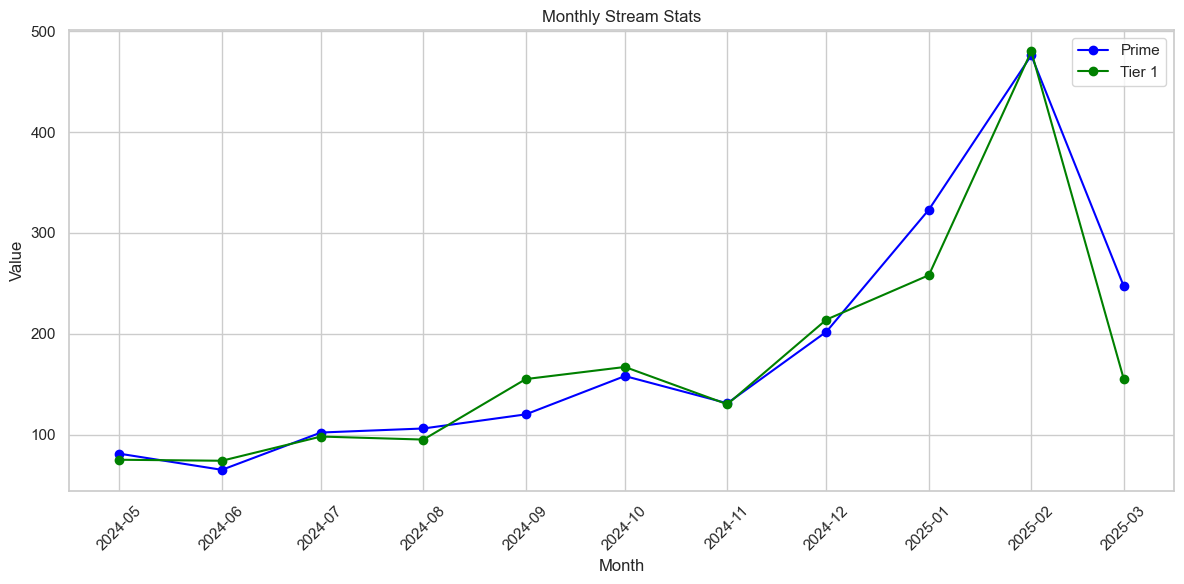

In [10]:
# Convert year_month to datetime for plotting
monthly_data['year_month'] = monthly_data['year_month'].dt.to_timestamp()

# Set the style for the plot
sns.set(style="whitegrid")

# Plotting the data
plt.figure(figsize=(12, 6))

# Plotting each column separately with a different color
plt.plot(monthly_data['year_month'], monthly_data['prime'], marker='o', label='Prime', color='blue')
plt.plot(monthly_data['year_month'], monthly_data['tier1'], marker='o', label='Tier 1', color='green')

# Adding titles and labels
plt.title('Monthly Stream Stats')
plt.xlabel('Month')
plt.ylabel('Value')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

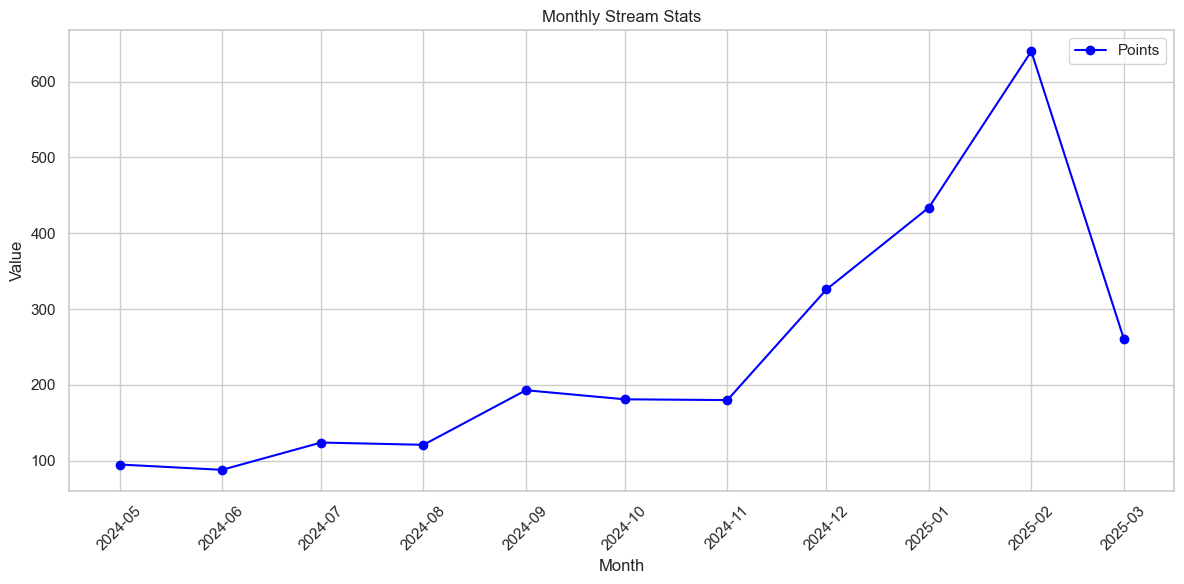

In [11]:
# Set the style for the plot
sns.set(style="whitegrid")

# Plotting the data
plt.figure(figsize=(12, 6))

# Plotting each column separately with a different color
plt.plot(monthly_data['year_month'], monthly_data['PartnerPlus'], marker='o', label='Points', color='blue')

# Adding titles and labels
plt.title('Monthly Stream Stats')
plt.xlabel('Month')
plt.ylabel('Value')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

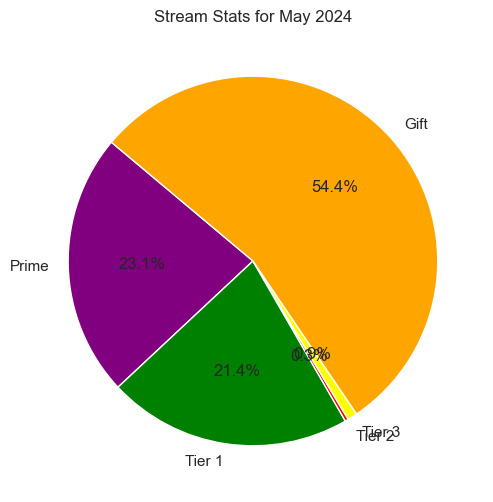

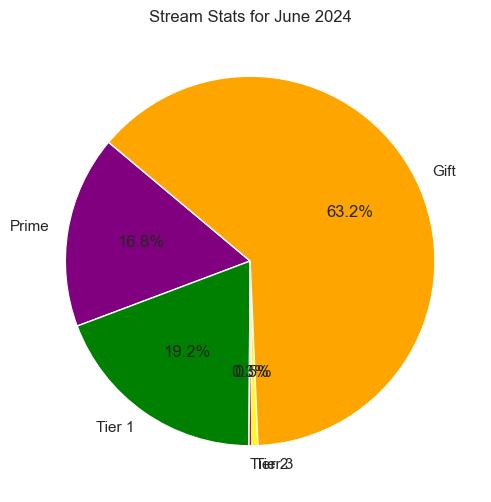

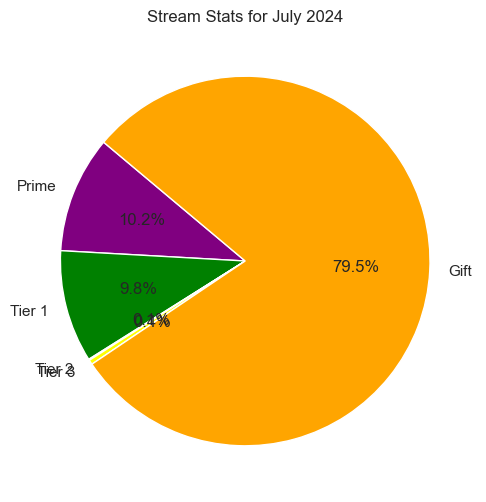

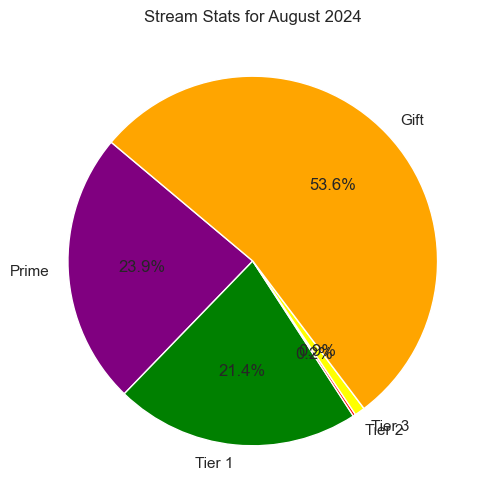

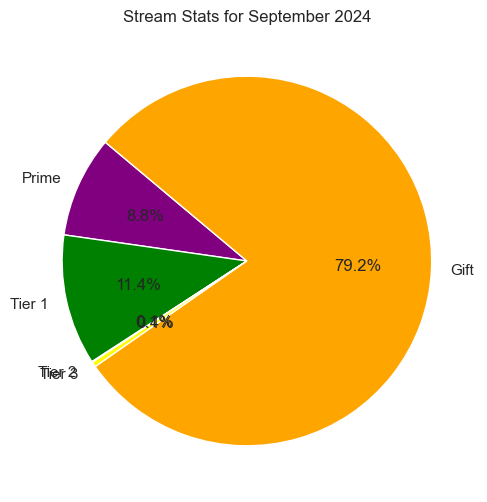

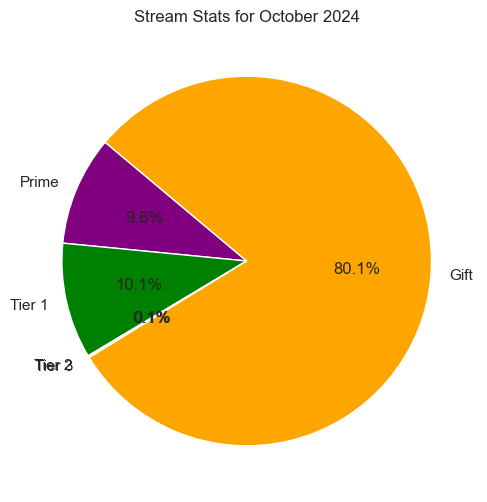

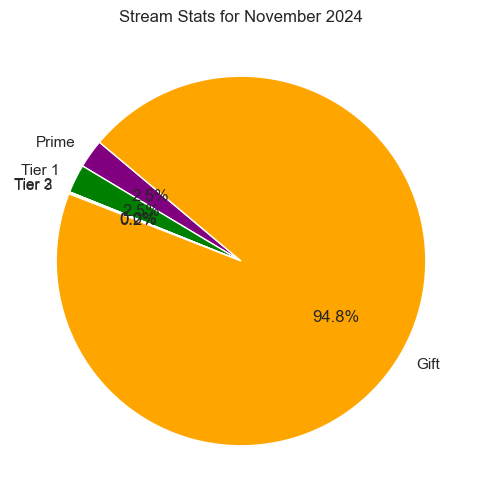

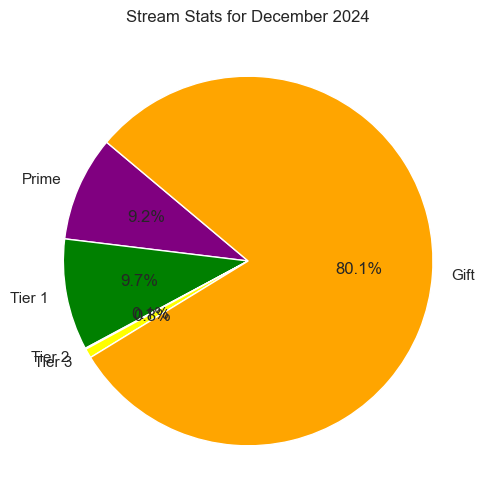

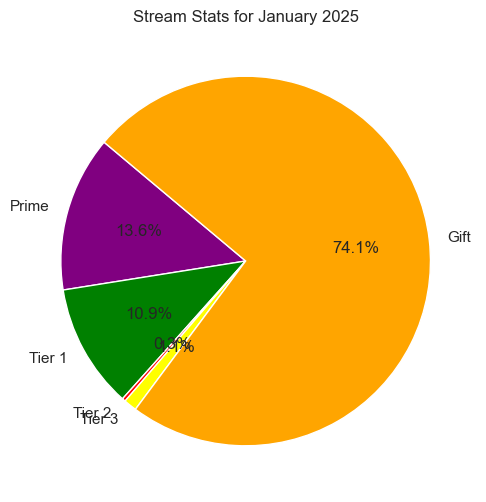

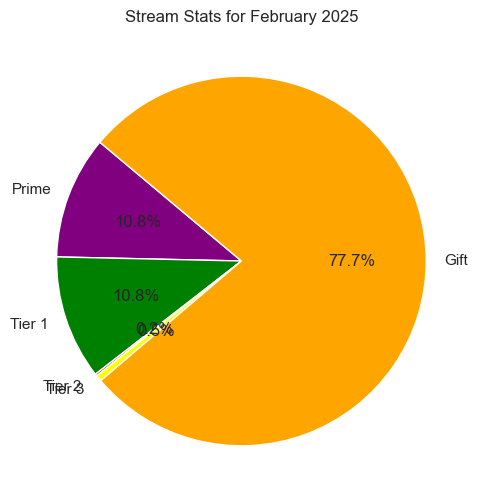

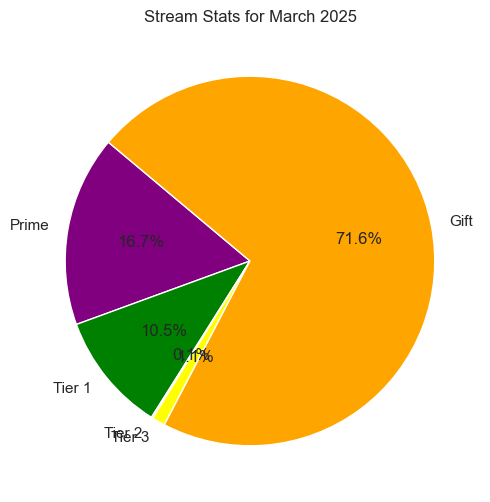

In [12]:
# Iterate through each row in the DataFrame to create a pie chart for each month
for index, row in monthly_data.iterrows():
    # Extract data for the current month
    labels = ['Prime', 'Tier 1', 'Tier 2', 'Tier 3', 'Gift']
    sizes = [row['prime'], row['tier1'], row['tier2'], row['tier3'], row['gift']]
    
    # Create a pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['purple','green', 'red', 'yellow', 'orange'])
    
    # Title the chart with the corresponding month
    plt.title(f"Stream Stats for {row['year_month'].strftime('%B %Y')}")
    
    # Display the plot
    plt.show()

In [13]:
#monthly_data.to_csv('month_data_output.csv', index=False)

In [14]:
monthly_data['sub_rev'] = monthly_data['prime'] * 1.4 + monthly_data['tier1'] * 1.4 + monthly_data['tier2'] * 2.8 + monthly_data['tier3'] * 5 + monthly_data['gift'] * 1.4
monthly_data

,year_month,prime,tier1,tier2,tier3,gift,ad_rev,avg,PartnerPlus,sub_rev
0,2024-05-01,81.0,75.0,1.0,3.0,191.0,98.621302,163.931034,95.0,503.6
1,2024-06-01,65.0,74.0,1.0,2.0,244.0,99.460279,205.956522,88.0,549.0
2,2024-07-01,102.0,98.0,1.0,4.0,793.0,118.660999,208.777778,124.0,1413.0
3,2024-08-01,106.0,95.0,1.0,4.0,238.0,115.630142,241.380952,121.0,637.4
4,2024-09-01,120.0,155.0,1.0,6.0,1074.0,177.910924,274.615385,193.0,1921.4
5,2024-10-01,158.0,167.0,1.0,2.0,1323.0,186.066281,344.384615,181.0,2320.0
6,2024-11-01,131.0,130.0,1.0,8.0,4937.0,200.659684,404.041667,180.0,7320.0
7,2024-12-01,202.0,214.0,2.0,18.0,1760.0,283.674678,494.074074,326.0,3142.0
8,2025-01-01,323.0,258.0,7.0,27.0,1756.0,369.612638,738.076923,434.0,3426.4
9,2025-02-01,476.0,480.0,8.0,24.0,3436.0,1030.490901,2216.916667,640.0,6291.2


In [15]:
stream_stats.tail(5)

,stream,first_messages,total_messages,stream_length,stream_length_hour,avg,max,follow,games,one_message_user_count,...,gift2,gift,prime,tier1,tier2,tier3,stream_date,ad_rev,stream_points,year_month
263,263,223,6550,21265.0,5.906944,1074,1219,3,"jc, lol, repo, crab",426,...,14.0,14.0,9.0,11.0,0.0,2.0,2025-03-11,25.376233,23.0,2025-03
264,264,259,7313,16749.0,4.652500,1218,1620,132,"jc, cs, cp",437,...,44.0,44.0,17.0,9.0,0.0,2.0,2025-03-12,22.666980,21.0,2025-03
265,265,667,24420,44178.0,12.271667,1154,1705,187,"jc, carb, r6, repo, tf2, cs, marbels",862,...,85.0,88.0,38.0,21.0,0.0,2.0,2025-03-14,56.646013,33.0,2025-03
266,266,153,3571,10794.0,2.998333,1197,1403,83,"jc, cs, tf2",326,...,84.0,84.0,14.0,6.0,0.0,0.0,2025-03-15,14.356020,6.0,2025-03
267,267,311,10432,19371.0,5.380833,975,1223,61,"jc, lol, r6, cp, marbels",469,...,11.0,12.0,12.0,10.0,0.0,2.0,2025-03-16,20.985250,22.0,2025-03


In [16]:
stream_stats['stream_date'] 

0     2024-05-01
1     2024-05-02
2     2024-05-03
3     2024-05-04
4     2024-05-05
         ...    
263   2025-03-11
264   2025-03-12
265   2025-03-14
266   2025-03-15
267   2025-03-16
Name: stream_date, Length: 268, dtype: datetime64[ns]